# First Model tuning an A into an Ä

In [1]:
# forcing the notebook to reload the modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
from src.data import datarenderer
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from src.data import fontdb_handler as fh
import datetime
from contextlib import redirect_stdout
from src.model import helperfunctions as hf

2023-11-26 11:40:09.069911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 11:40:09.069973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 11:40:09.071549: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:40:09.203404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Checking if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


2023-11-26 11:40:11.942392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:40:11.967139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:40:11.967180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


## Creating the Data

In [5]:
trainings_list = []

In [6]:
charset = "AÄ8Bjß"
box_size = 64
num_glyphs = len(charset)
test_size = 0.1
batch_size = 64

In [7]:
PATH_JSON_FONT_DB = '../data/raw/00dataset.json'
font_file_paths = fh.font_file_list(PATH_JSON_FONT_DB) # List with all the paths to the fonts

np.random.seed(42)
font_file_paths = np.random.permutation(font_file_paths)
num_samples = len(font_file_paths)
num_samples

21314

In [8]:
num_test_samples = int(num_samples * test_size)
dataset_train = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=box_size, chars=charset, normalize=True).astype(np.float32))
dataset_test = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=box_size, chars=charset, normalize=True).astype(np.float32))

2023-11-26 11:41:11.772048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:41:11.772119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:41:11.772141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:41:12.056834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 11:41:12.056881: I tensorflow/compile

2023-11-26 11:43:45.920542: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1885765632 exceeds 10% of free system memory.


(64, 64, 6)


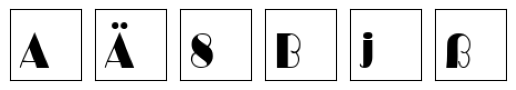

In [9]:
example = next(iter(dataset_train))
print(example.shape)

hf.render_charset(example)

In [10]:
def encode(image):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, image

In [11]:
img1, img2 = encode(example)
print(img1.shape)
print(img2.shape)

(64, 64, 6)
(64, 64, 6)


In [12]:
dataset_train = dataset_train.map(lambda image: encode(image)).shuffle(num_samples - num_test_samples).batch(batch_size)
dataset_test = dataset_test.map(lambda image: encode(image)).batch(batch_size)

In [13]:
class AutoEncoder(tf.keras.Model):

  def __init__(self, latent_dim, *args, **kwargs):
    assert isinstance(latent_dim, int)
    super().__init__(*args, **kwargs)
    self.latent_dim = latent_dim

    # Encoder
    self.encoder_reshape = layers.Reshape((box_size*box_size*num_glyphs,))
    self.encoder_fc1 = layers.Dense(512, activation="relu")
    self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

    # TODO: Decoder
    self.decoder_fc1 = layers.Dense(512, activation="relu")
    self.decoder_fc2 = layers.Dense(box_size*box_size*num_glyphs, activation="sigmoid")
    self.decoder_reshape = layers.Reshape((box_size, box_size, num_glyphs))

    self._build_graph()

  def _build_graph(self): # Just here because we want to see the output shapes in the summary.
    input_shape = (box_size, box_size, num_glyphs)
    self.build( (None,) + input_shape ) # (None, 28, 28, 1)
    inputs = tf.keras.Input(shape=input_shape)
    _ = self.call(inputs)

  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    encoded = self.encoder_reshape(x)
    encoded = self.encoder_fc1(encoded)
    encoded = self.encoder_fc2(encoded)
    return encoded

  def decode(self, z):
    decoded = self.decoder_fc1(z)
    decoded = self.decoder_fc2(decoded)
    decoded = self.decoder_reshape(decoded)
    return decoded

model = AutoEncoder(128)

model.summary()
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy"
)

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 512)               12583424  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 24576)             12607488  
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 6)         0         
                                                                 
Total params: 25322624 (96.60 MB)
Trainable params: 25

In [14]:
trainings_list.append({
    "charset": charset,
    "box_size": box_size,
    "test_size": test_size,
    "batch_size": batch_size,
    "history": model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_test
)})

2023-11-26 11:44:33.189150: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1885765632 exceeds 10% of free system memory.


Epoch 1/10


2023-11-26 11:44:34.919247: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 11:44:36.340175: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f70582313f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 11:44:36.340227: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-11-26 11:44:36.348110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 11:44:36.372916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 11:44:36.447516: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 8s 15ms/step - loss: 0.1295 - val_loss: 0.1081
Epoch 2/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0986 - val_loss: 0.0953
Epoch 3/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0895 - val_loss: 0.0896
Epoch 4/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0838 - val_loss: 0.0842
Epoch 5/10
300/300 [==============================] - 5s 13ms/step - loss: 0.0799 - val_loss: 0.0823
Epoch 6/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0766 - val_loss: 0.0793
Epoch 7/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0746 - val_loss: 0.0782
Epoch 8/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0729 - val_loss: 0.0761
Epoch 9/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0712 - val_loss: 0.0749
Epoch 10/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0700 - val_loss: 0.0758



The summary of the model with the best val_loss during training:
Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 512)               12583424  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 24576)             12607488  
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 6)         0         
                                                      

None

The other parameters of the best training:
charset: AÄ8Bjß
box_size: 64
test_size: 0.1
batch_size: 64


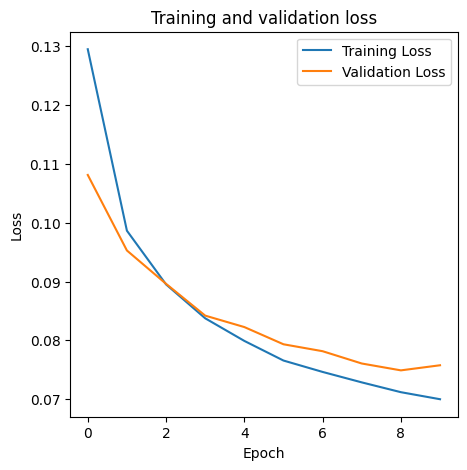

In [15]:
hf.analyze_trainings(trainings_list)

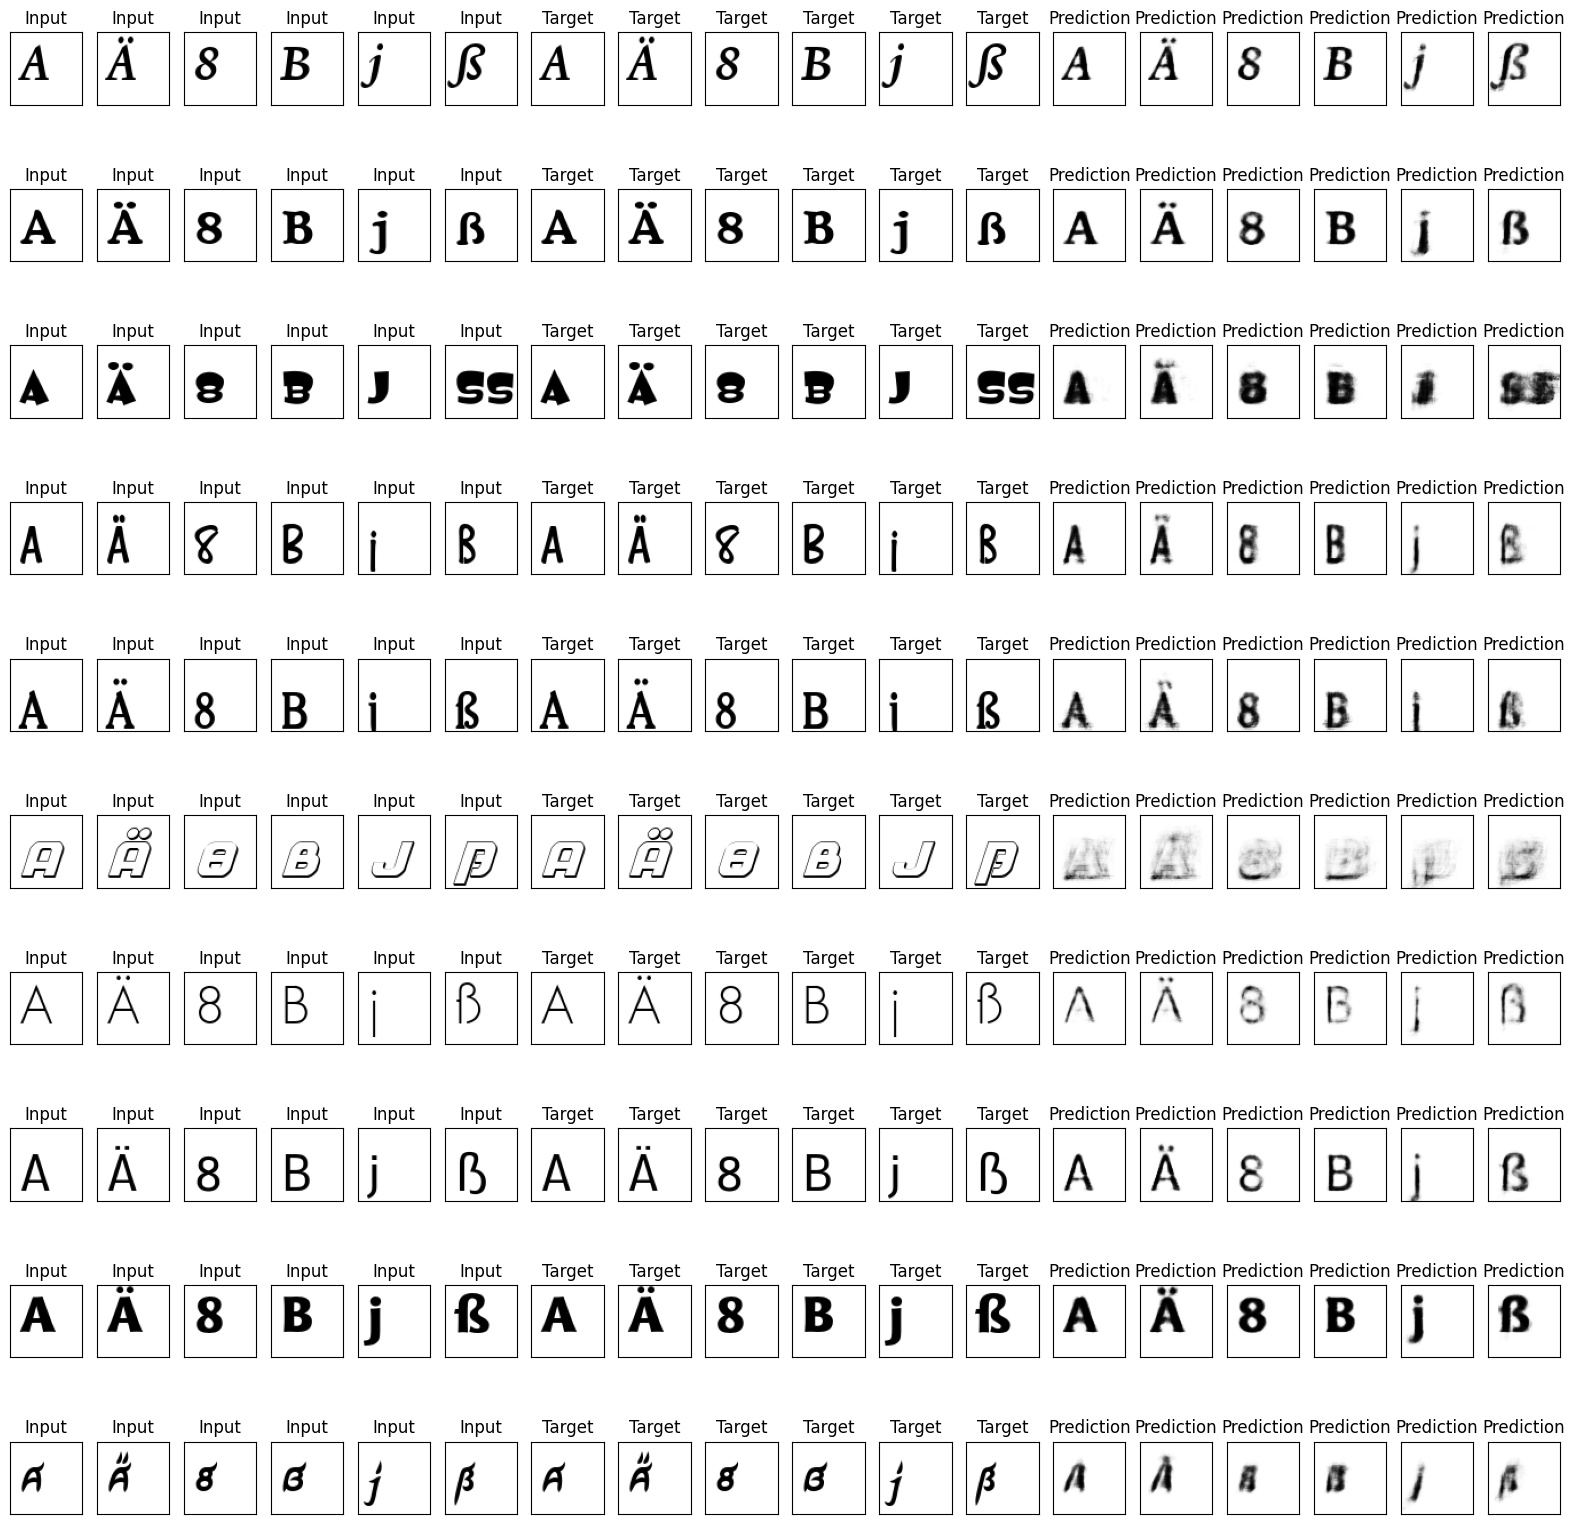

In [16]:
hf.render_predictions(model, dataset_test, num_examples=10, figsize=(20, 20))

# Model with different input and output

## Defenitions

In [17]:
if "trainings_list" not in locals():
    trainings_list = []

In [18]:
charset_in = "AaOoUu8Bj"
charset_out = "ÄäÖöÜüß"
box_size = 64
#num_glyphs = len(charset)
test_size = 0.1
batch_size = 32

In [19]:
PATH_JSON_FONT_DB = '../data/raw/00dataset.json'
font_file_paths = fh.font_file_list(PATH_JSON_FONT_DB) # List with all the paths to the fonts

np.random.seed(42)
font_file_paths = font_file_paths#[:100]
font_file_paths = np.random.permutation(font_file_paths)
num_samples = len(font_file_paths)
num_samples

21314

## Creating the Data

In [20]:
num_test_samples = int(num_samples * test_size)
len_charset_in = len(charset_in)
len_charset_out = len(charset_out)
dataset_train = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[:-num_test_samples], 
                                                                     size=box_size, 
                                                                     chars=charset_in + charset_out, 
                                                                     normalize=True))
dataset_test = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[-num_test_samples:], 
                                                                    size=box_size, 
                                                                    chars=charset_in + charset_out, 
                                                                    normalize=True))


2023-11-26 11:49:58.906342: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2514354176 exceeds 10% of free system memory.


(64, 64, 16)


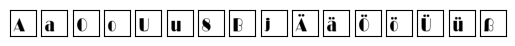

In [21]:
example = next(iter(dataset_train))
print(example.shape)

hf.render_charset(example)

In [22]:
dataset_train = dataset_train.map(lambda image: (image[:,:,:len(charset_in)], image[:,:,len(charset_in):])).shuffle(num_samples - num_test_samples).batch(batch_size)
dataset_test = dataset_test.map(lambda image: (image[:,:,:len(charset_in)], image[:,:,len(charset_in):])).batch(batch_size)

## Creating the Model

In [23]:
class AutoEncoder(tf.keras.Model):

  def __init__(self, latent_dim, *args, **kwargs):
    assert isinstance(latent_dim, int)
    super().__init__(*args, **kwargs)
    self.latent_dim = latent_dim

    self.inverter_layer = lambda x: 1 - x

    # Encoder
    self.encoder_conv2d_1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")
    self.encoder_maxpool_1 = layers.MaxPooling2D((2, 2), padding="same")
    self.encoder_conv2d_2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")
    self.encoder_maxpool_2 = layers.MaxPooling2D((2, 2), padding="same")
    self.encoder_dropout_1 = layers.Dropout(0.1)
    self.encoder_conv2d_3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")
    self.encoder_maxpool_3 = layers.MaxPooling2D((2, 2), padding="same")
    self.encoder_flatten = layers.Flatten()
    self.encoder_dropout_2 = layers.Dropout(0.1)
    self.encoder_fc1 = layers.Dense(512, activation="relu")
    self.encoder_dropout_3 = layers.Dropout(0.1)
    self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

    # TODO: Decoder
    self.decoder_dropout_1 = layers.Dropout(0.1)
    self.decoder_fc1 = layers.Dense(512, activation="relu")
    self.decoder_reshape = layers.Reshape((4, 4, 32))
    self.decoder_upsample_1 = layers.UpSampling2D((2, 2))
    self.decoder_conv2d_1 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")
    self.decoder_dropout_2 = layers.Dropout(0.1)
    self.decoder_upsample_2 = layers.UpSampling2D((2, 2))
    self.decoder_conv2d_2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")
    self.decoder_dropout_3 = layers.Dropout(0.1)
    self.decoder_upsample_3 = layers.UpSampling2D((2, 2))
    self.decoder_conv2d_3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")
    self.decoder_out = layers.Conv2DTranspose(len(charset_out), (3, 3), strides=(2, 2), padding="same")

    self._build_graph()

  def _build_graph(self): # Just here because we want to see the output shapes in the summary.
    input_shape = (box_size, box_size, len(charset_in))
    self.build( (None,) + input_shape ) # (None, 28, 28, 1)
    inputs = tf.keras.Input(shape=input_shape)
    _ = self.call(inputs)

  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    encoded = self.inverter_layer(x)
    encoded = self.encoder_conv2d_1(encoded)
    encoded = self.encoder_maxpool_1(encoded)
    encoded = self.encoder_conv2d_2(encoded)
    encoded = self.encoder_maxpool_2(encoded)
    #encoded = self.encoder_dropout_1(encoded)
    encoded = self.encoder_conv2d_3(encoded)
    encoded = self.encoder_maxpool_3(encoded)
    encoded = self.encoder_flatten(encoded)
    #encoded = self.encoder_dropout_2(encoded)
    encoded = self.encoder_fc1(encoded)
    #encoded = self.encoder_dropout_3(encoded)
    encoded = self.encoder_fc2(encoded)
    return encoded

  def decode(self, decoded):
    #decoded = self.decoder_dropout_1(decoded)
    decoded = self.decoder_fc1(decoded)
    decoded = self.decoder_reshape(decoded)
    decoded = self.decoder_upsample_1(decoded)
    decoded = self.decoder_conv2d_1(decoded)
    #decoded = self.decoder_dropout_2(decoded)
    decoded = self.decoder_upsample_2(decoded)
    decoded = self.decoder_conv2d_2(decoded)
    #decoded = self.decoder_dropout_3(decoded)
    decoded = self.decoder_upsample_3(decoded)
    decoded = self.decoder_conv2d_3(decoded)
    decoded = self.decoder_out(decoded)
    decoded = self.inverter_layer(decoded)
    return decoded


In [24]:
model = AutoEncoder(128)

model.compile(
    optimizer = "adam",
    loss = "mse"
)

model.summary()

Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2624      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)    

## Training the Model

In [25]:
trainings_list.append({
    "charset_in": charset_in,
    "charset_out": charset_out,
    "box_size": box_size,
    "test_size": test_size,
    "batch_size": batch_size,
    "history": model.fit(
        dataset_train,
        epochs=50,
        validation_data=dataset_test
)})

Epoch 1/50


2023-11-26 11:50:15.601584: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


600/600 [==============================] - 19s 16ms/step - loss: 0.0315 - val_loss: 0.0264
Epoch 2/50
600/600 [==============================] - 14s 15ms/step - loss: 0.0242 - val_loss: 0.0236
Epoch 3/50
600/600 [==============================] - 13s 14ms/step - loss: 0.0221 - val_loss: 0.0221
Epoch 4/50
600/600 [==============================] - 11s 14ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 5/50
600/600 [==============================] - 12s 14ms/step - loss: 0.0200 - val_loss: 0.0205
Epoch 6/50
600/600 [==============================] - 10s 14ms/step - loss: 0.0193 - val_loss: 0.0201
Epoch 7/50
600/600 [==============================] - 10s 15ms/step - loss: 0.0189 - val_loss: 0.0198
Epoch 8/50
600/600 [==============================] - 11s 15ms/step - loss: 0.0184 - val_loss: 0.0194
Epoch 9/50
600/600 [==============================] - 11s 15ms/step - loss: 0.0181 - val_loss: 0.0193
Epoch 10/50
600/600 [==============================] - 12s 15ms/step - loss: 0.0178 - val_los

## Analyzing the Model

### On the Validation Set

###############################
Best training was the last one!
###############################
Best training was the last one!
###############################
Best training was the last one!
###############################

The summary of the model with the best val_loss during training:
Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2624      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                     

None

The other parameters of the best training:
charset_in: AaOoUu8Bj
charset_out: ÄäÖöÜüß
box_size: 64
test_size: 0.1
batch_size: 32


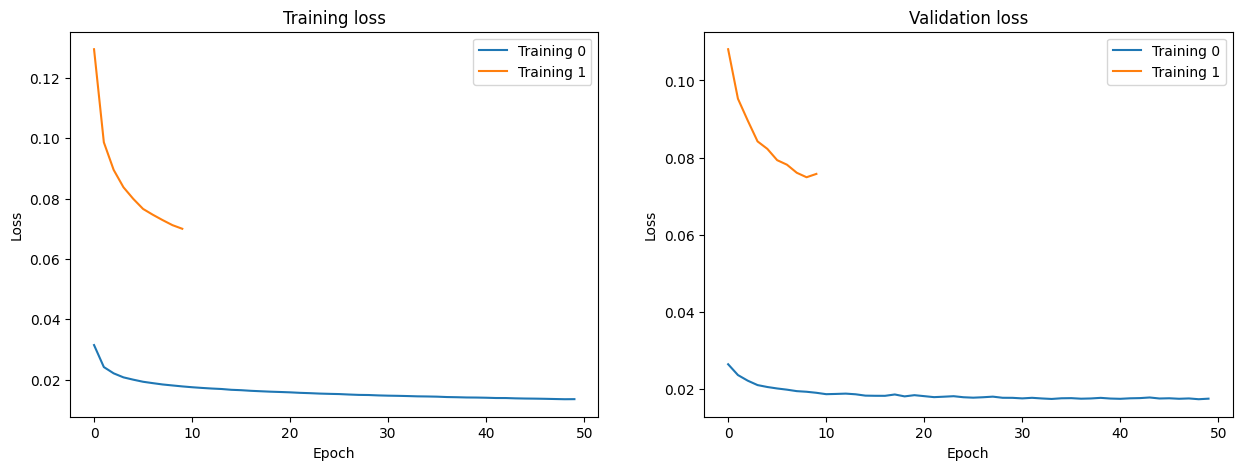

In [26]:
hf.analyze_trainings(trainings_list)
#render_predictions(model, dataset_test, num_examples=10, figsize=(20, 20))
#render_predictions(model, dataset_test, num_examples=10, figsize=(20, 20), black_white=True)

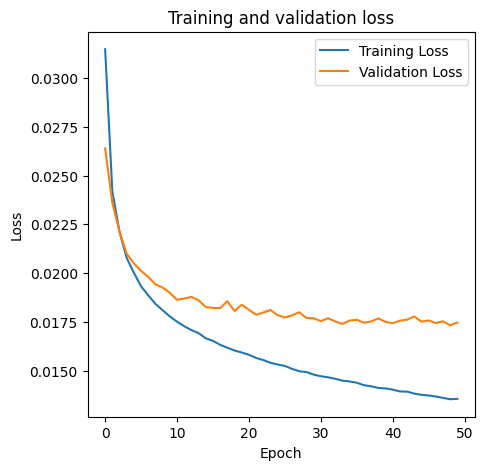

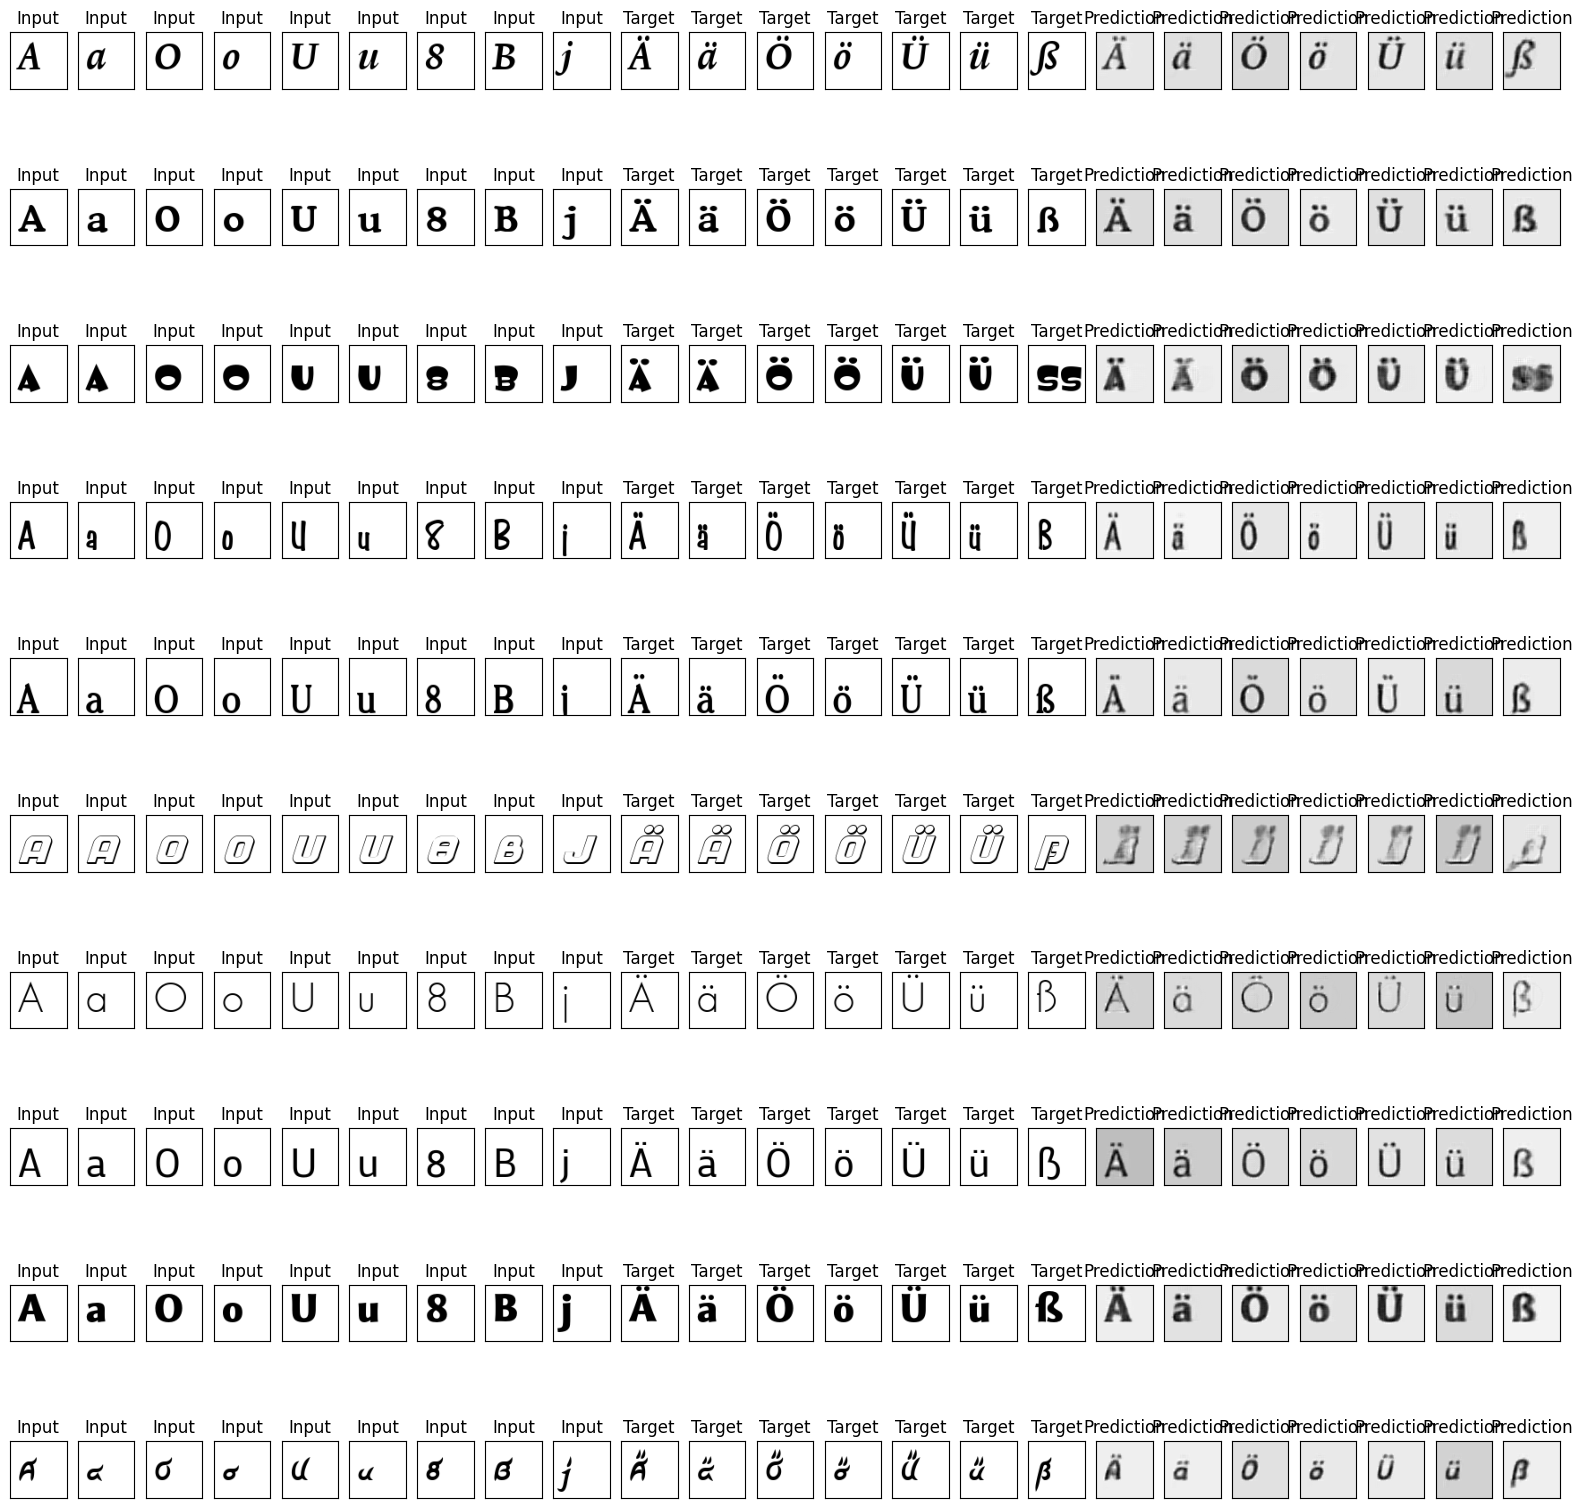

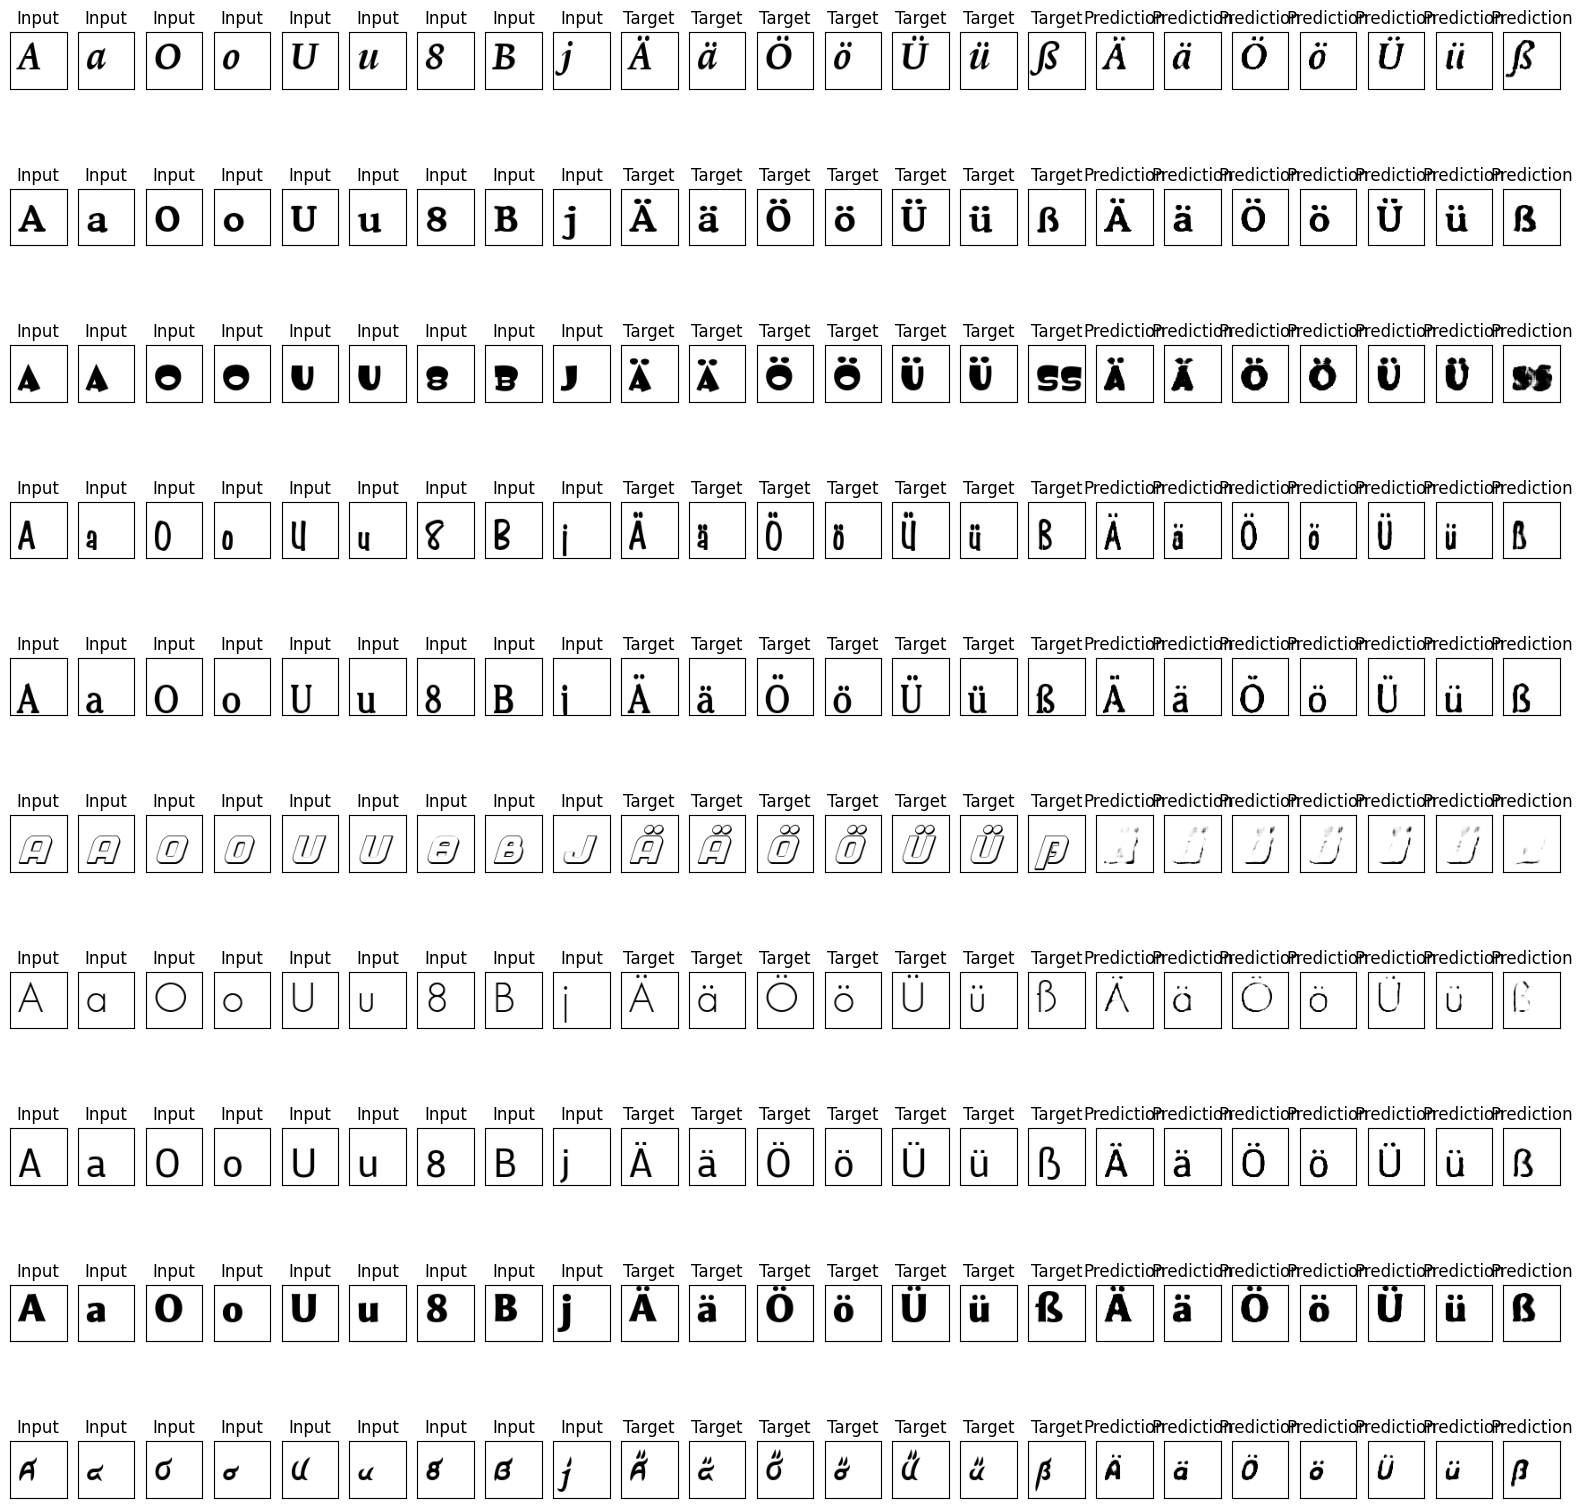

In [29]:
hf.save_summary_last_training(
                           trainings_list=trainings_list,
                           dataset_test=dataset_test,
                           save_path_summary="../models/logs/",
                           save_path_model="../models/" 
                           )

### On the Training Set

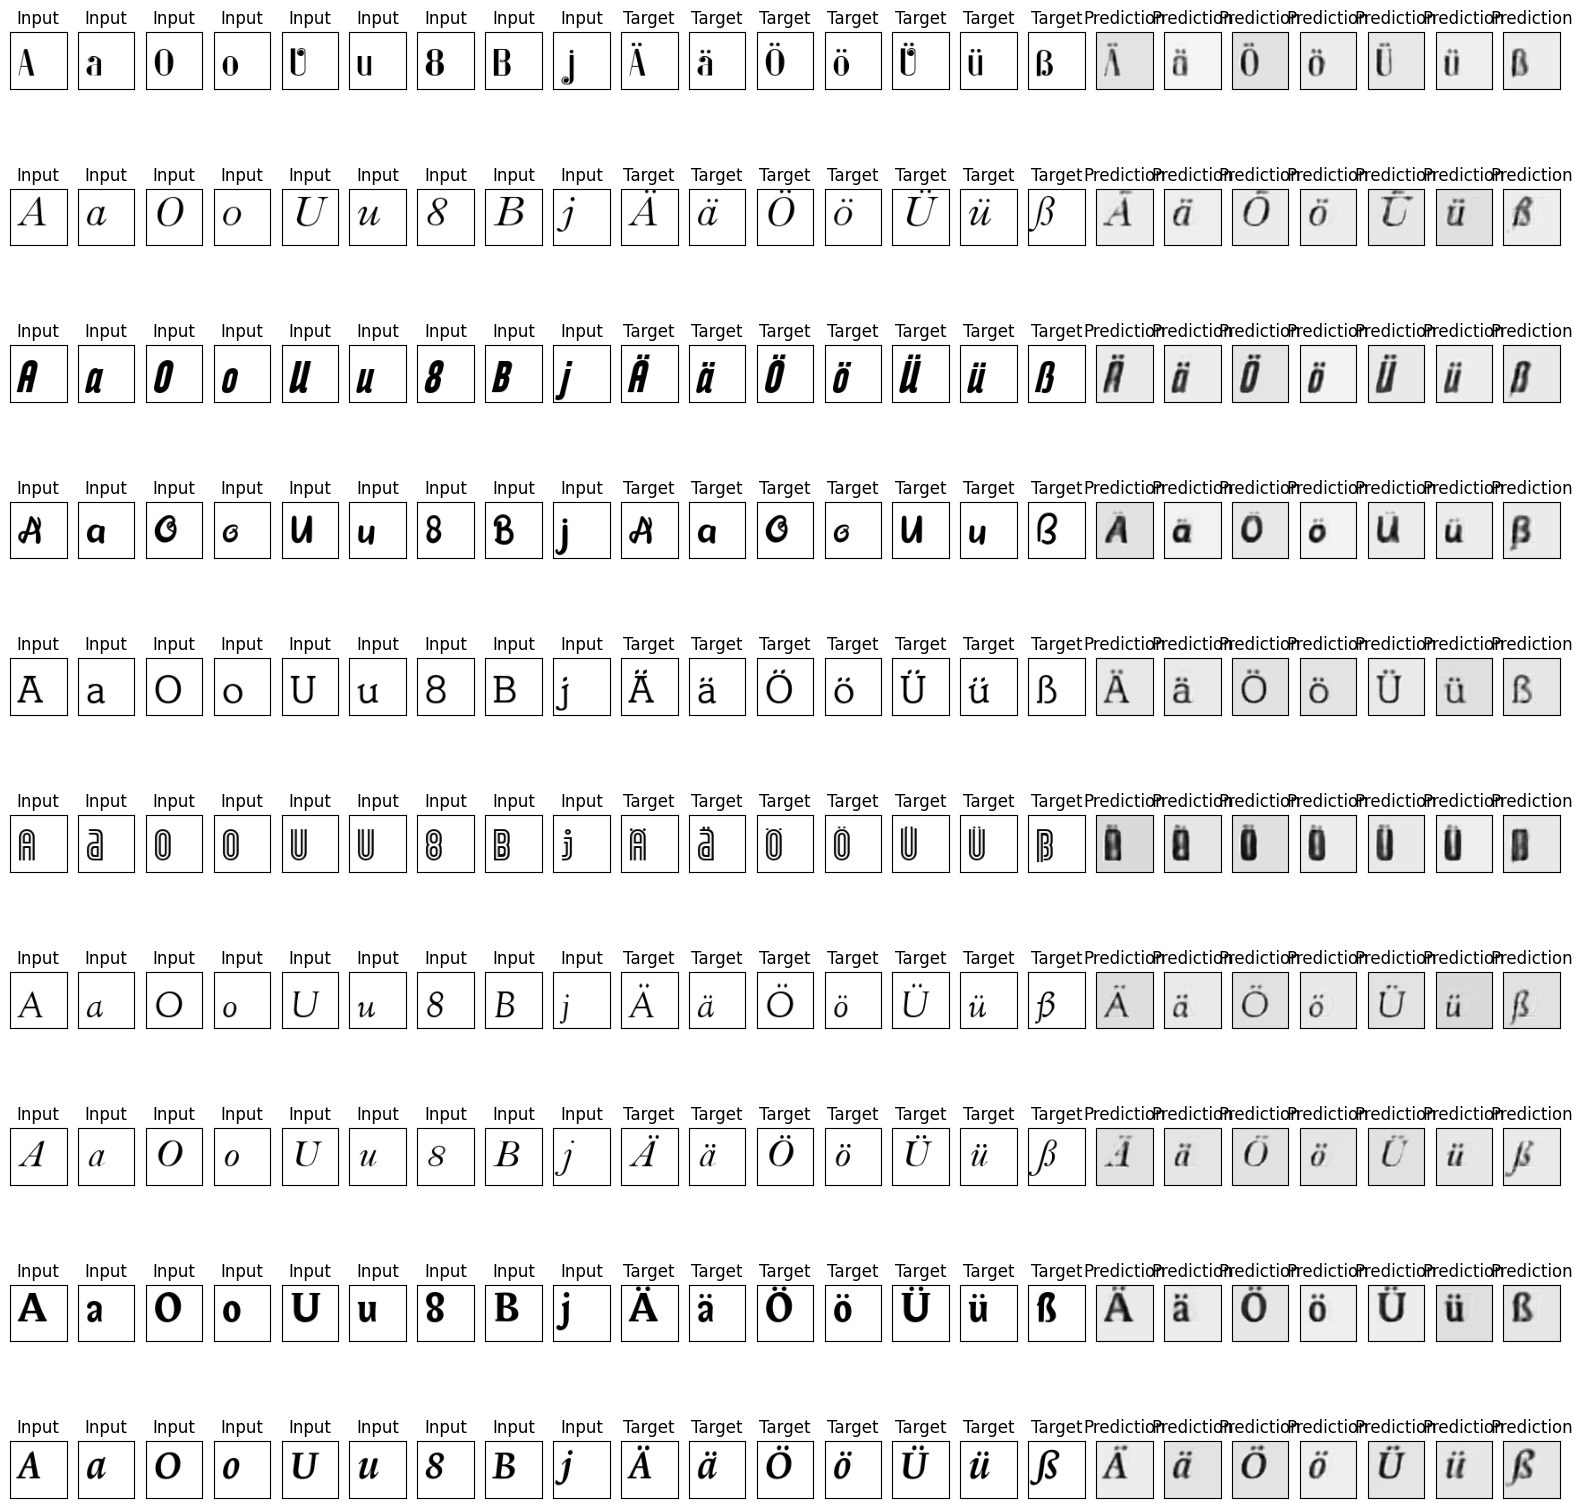

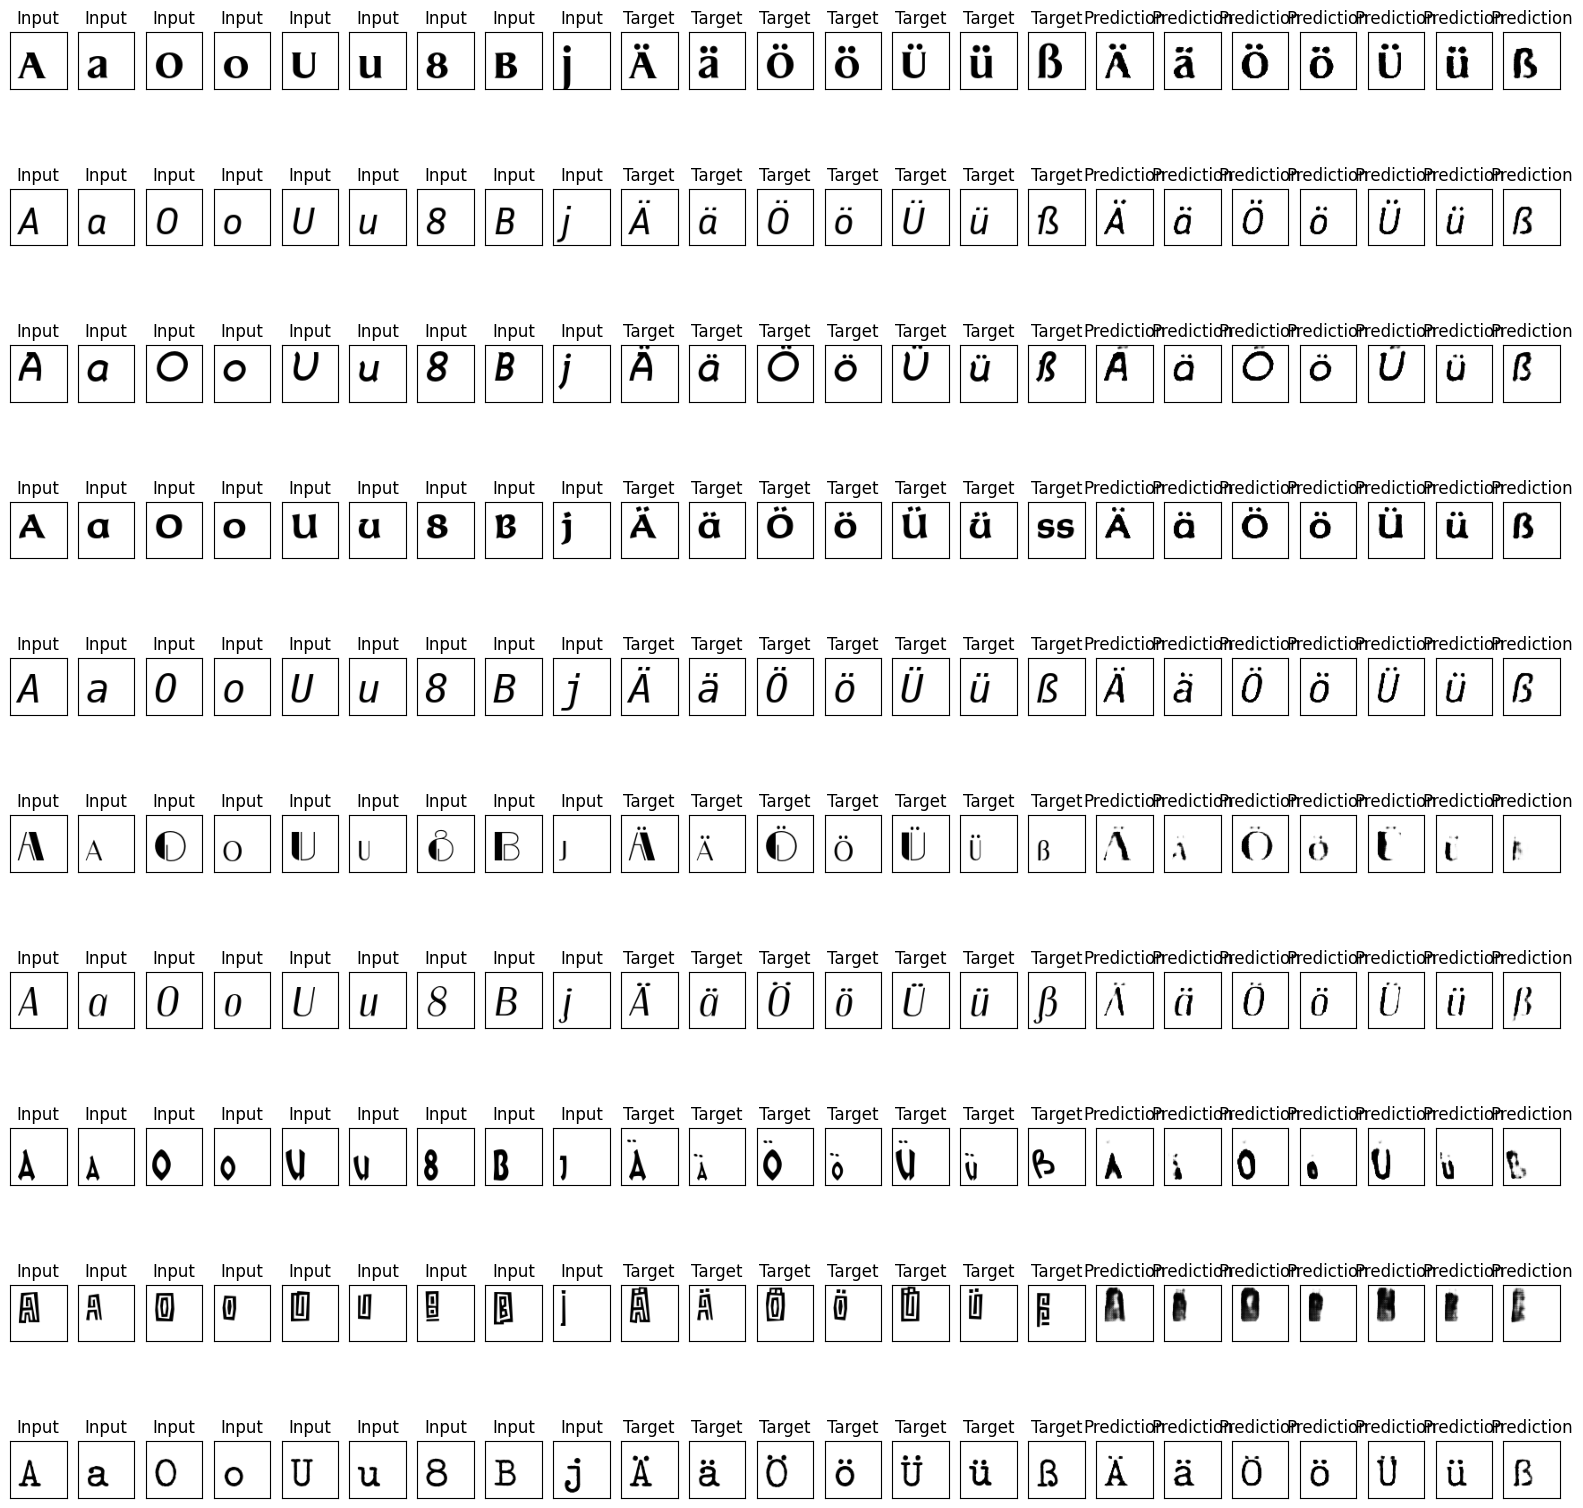

In [ ]:
hf.render_predictions(model, dataset_train, num_examples=10, figsize=(20, 20))
hf.render_predictions(model, dataset_train, num_examples=10, figsize=(20, 20), black_white=True)